# 3. scATAC profiles of fetal tissues from the fetal cell atlas dataset
Domcke S, Hill AJ, Daza RM, Cao J, O’Day DR, Pliner HA, et al. A human cell atlas of fetal chromatin accessibility. Science. 2020;370:eaba7612

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro

# scCODA functions
import sccoda
from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

#Setup path to R for propeller
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

2023-07-04 11:23:22.826630: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 11:23:22.830296: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 11:23:22.906407: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 11:23:22.909268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 11:23:25.057857: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

In [3]:
def convert_counts_to_df(counts, prop_cols=None, meta_cols=None, n_cells=1, column_name="Cluster"):
    """ Convert a cell count matrix to a dataframe in long format."""

    counts = counts.copy()

    #If not given, try to get prop_cols and meta_cols automatically
    if prop_cols is None:
        dtypes = counts.dtypes.astype(str)
        prop_cols = [col for i, col in enumerate(counts.columns) if "float" in dtypes[i] or "int" in dtypes[i]]
        
    if meta_cols is None:
        meta_cols = [col for col in counts.columns if col not in prop_cols]

    # Multiply proportions with n_cells
    counts[prop_cols] *= n_cells
    counts[prop_cols] = counts[prop_cols].astype(int)
    
    # Melt into long format (similar to adata.obs)
    counts_melt = pd.melt(counts, id_vars=meta_cols, value_vars=prop_cols, 
                          var_name=column_name, value_name="count")

    # Duplicate rows based on number of cells
    counts_long = counts_melt.loc[counts_melt.index.repeat(counts_melt["count"])].reset_index(drop=True)
    counts_long.drop(columns="count", inplace=True)
    counts_long.index = ["cell_" + str(i) for i in range(1, len(counts_long) + 1)]
    
    return counts_long

------------------

## Read data

In [4]:
fetal_scatac_counts = pd.read_csv("data/scATAC_counts.tsv", sep='\t')

In [5]:
# Subset to heart and muscle
fetal_scatac_counts = fetal_scatac_counts[fetal_scatac_counts['tissue'].isin(['heart', 'muscle'])]

# Remove celltypes not in heart/muscle
fetal_scatac_counts = fetal_scatac_counts.loc[:, fetal_scatac_counts.sum(axis=0) != 0]

In [6]:
fetal_scatac = convert_counts_to_df(fetal_scatac_counts, column_name="cell_type")

In [7]:
fetal_scatac.head()

,sample_name,sex,tissue,cell_type
cell_1,sample_12_heart,male,heart,Cardiomyocytes
cell_2,sample_12_heart,male,heart,Cardiomyocytes
cell_3,sample_12_heart,male,heart,Cardiomyocytes
cell_4,sample_12_heart,male,heart,Cardiomyocytes
cell_5,sample_12_heart,male,heart,Cardiomyocytes


------------

## Run Scanpro

### Heart vs Muscle with replicates

In [8]:
scanpro_out = scanpro.scanpro(fetal_scatac, clusters_col='cell_type',
                                   conds_col='tissue', samples_col='sample_name')
scanpro_out.results

[INFO] There are 2 conditions. T-Test will be performed...
[INFO] Done!


,baseline_props,mean_props_heart,mean_props_muscle,prop_ratio,t_statistics,p_values,adjusted_p_values
cell_type,,,,,,,
Cardiomyocytes,0.431646,0.588339,-2.947251e-17,-1.996230e+16,45.733689,6.680748e-11,1.002112e-09
Cardiomyocytes/Endothelial cells,0.034443,0.054096,-3.333832e-18,-1.622650e+16,28.679405,2.657784e-09,9.583216e-09
Endocardial cells,0.034405,0.039980,-3.174682e-18,-1.259339e+16,32.488374,9.951835e-10,7.463876e-09
Epicardial fat cells,0.003507,0.003482,-2.337658e-19,-1.489456e+16,18.632467,7.782089e-08,1.459142e-07
Erythroblasts,0.021854,0.020594,-1.756275e-18,-1.172614e+16,24.474756,9.236937e-09,2.309234e-08
Lymphatic endothelial cells,0.004426,0.004911,-3.725243e-19,-1.318322e+16,28.016812,3.194405e-09,9.583216e-09
Lymphoid and Myeloid cells,0.007895,0.000000,3.780331e-02,0.000000e+00,-11.818051,2.569825e-06,3.504307e-06
Lymphoid cells,0.051919,0.042639,-3.686234e-18,-1.156709e+16,18.987335,6.719565e-08,1.439907e-07
Myeloid cells,0.025475,0.026746,-2.063297e-18,-1.296251e+16,30.431276,1.666405e-09,8.332025e-09


In [9]:
scanpro_out.results.to_csv("results/scatac_scanpro_rep.tsv", sep="\t")

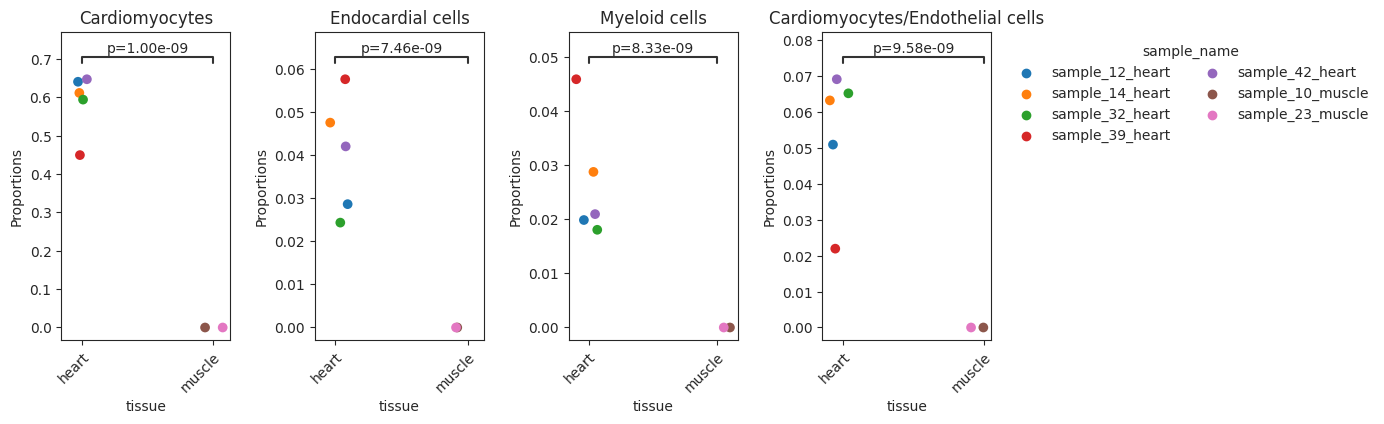

In [10]:
# Show clusters with most significant changes
show_clusters = scanpro_out.results.sort_values("adjusted_p_values").index[:4].tolist()

scanpro_out.plot(clusters=show_clusters, n_columns=4, save=f"{FIG_PATH}/scatac_heart_muscle.pdf")

### Without replicates

In [11]:
scanpro_out_norep = scanpro.scanpro(fetal_scatac, clusters_col='cell_type',
                                    conds_col='tissue')
scanpro_out_norep.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 30.79 seconds


,baseline_props,mean_props_heart,mean_props_muscle,p_values
cell_type,,,,
Cardiomyocytes,0.431646,0.546351,0.000000,1.656645e-09
Cardiomyocytes/Endothelial cells,0.034443,0.040970,0.000000,2.147129e-06
Endocardial cells,0.034405,0.040859,0.000000,2.778491e-06
Epicardial fat cells,0.003507,0.003226,0.000000,7.921490e-04
Erythroblasts,0.021854,0.026138,0.000000,5.441871e-06
Lymphatic endothelial cells,0.004426,0.004613,0.000000,5.064099e-04
Lymphoid and Myeloid cells,0.007895,0.000000,0.033914,1.786317e-06
Lymphoid cells,0.051919,0.061857,0.000000,1.093600e-06
Myeloid cells,0.025475,0.031216,0.000000,5.815130e-06


In [12]:
scanpro_out_norep.results.to_csv("results/scatac_scanpro_norep.tsv", sep="\t")

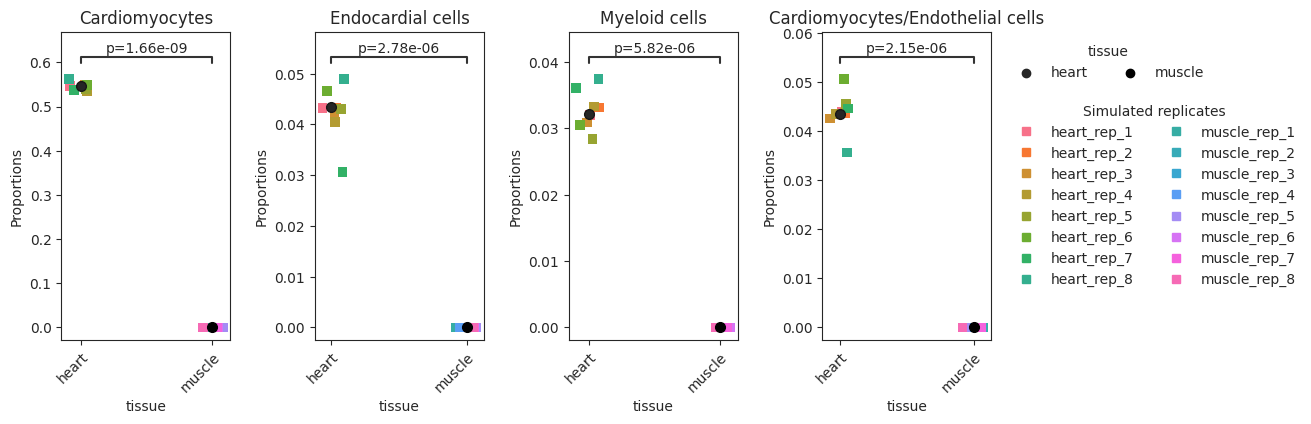

In [13]:
scanpro_out_norep.plot(clusters=show_clusters, n_columns=4, save=f"{FIG_PATH}/scatac_heart_muscle_norep.pdf")

-----------

## Propeller

In [14]:
%%R -i fetal_scatac -o propeller_results
library(speckle)

propeller_results = propeller(clusters = fetal_scatac$cell_type, sample = fetal_scatac$sample_name, group = fetal_scatac$tissue)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)
Performing logit transformation of proportions
group variable has 2 levels, t-tests will be performed


In [15]:
propeller_results

,BaselineProp.clusters,BaselineProp.Freq,PropMean.heart,PropMean.muscle,PropRatio,Tstatistic,P.Value,FDR
Cardiomyocytes,Cardiomyocytes,0.431646,0.588339,-7.373805e-18,-7.978773e+16,33.316133,7.742756e-10,1.161413e-08
Endocardial cells,Endocardial cells,0.034405,0.039980,7.550025e-19,5.295349e+16,20.565454,3.463344e-08,2.597508e-07
Myeloid cells,Myeloid cells,0.025475,0.026746,-7.067286e-19,-3.784410e+16,18.866743,6.796109e-08,3.038578e-07
Cardiomyocytes/Endothelial cells,Cardiomyocytes/Endothelial cells,0.034443,0.054096,-5.412654e-18,-9.994434e+15,18.446283,8.102876e-08,3.038578e-07
Lymphatic endothelial cells,Lymphatic endothelial cells,0.004426,0.004911,-1.647618e-19,-2.980709e+16,15.172386,3.693717e-07,1.074918e-06
Erythroblasts,Erythroblasts,0.021854,0.020594,-4.037663e-18,-5.100555e+15,14.876732,4.299671e-07,1.074918e-06
Lymphoid cells,Lymphoid cells,0.051919,0.042639,-2.285745e-18,-1.865431e+16,11.894994,2.669892e-06,5.721197e-06
Epicardial fat cells,Epicardial fat cells,0.003507,0.003482,-2.590576e-19,-1.344041e+16,9.945757,9.130608e-06,1.711989e-05
Skeletal muscle cells,Skeletal muscle cells,0.069193,-0.000000,3.239336e-01,0.000000e+00,-9.733645,2.364287e-05,3.940479e-05
Satellite cells,Satellite cells,0.049811,-0.000000,2.387881e-01,0.000000e+00,-9.344963,3.097340e-05,4.646009e-05


In [16]:
propeller_results.to_csv("results/scatac_propeller_rep.tsv", sep="\t")

----------

## scCODA

In [17]:
fetal_scatac_counts

,sample_name,sex,tissue,Cardiomyocytes,Cardiomyocytes/Endothelial cells,Endocardial cells,Epicardial fat cells,Erythroblasts,Lymphatic endothelial cells,Lymphoid and Myeloid cells,Lymphoid cells,Myeloid cells,Satellite cells,Schwann cells,Skeletal muscle cells,Smooth muscle cells,Stromal cells,Vascular endothelial cells
0,sample_10_muscle,male,muscle,0,0,0,0,0,0,483,0,0,3030,349,4713,441,2680,963
1,sample_12_heart,male,heart,10976,873,490,52,226,64,0,457,341,0,127,0,503,2140,891
2,sample_14_heart,male,heart,8573,887,666,54,221,61,0,332,404,0,160,0,259,1785,623
5,sample_23_muscle,male,muscle,0,0,0,0,0,0,341,0,0,2169,453,2509,385,2271,977
7,sample_32_heart,male,heart,9161,1006,375,20,205,57,0,265,279,0,109,0,663,2003,1283
11,sample_39_heart,male,heart,15819,773,2026,238,1617,276,0,4347,1618,0,376,0,649,6061,1410
13,sample_42_heart,female,heart,524,56,34,2,12,4,0,18,17,0,8,0,23,80,32


In [18]:
# With replicates
sccoda_data = dat.from_pandas(fetal_scatac_counts, covariate_columns=["sample_name", "sex", "tissue"])

# Without replicates
counts_merged = fetal_scatac_counts.groupby("tissue").sum(numeric_only=True).reset_index()
sccoda_data_norep = dat.from_pandas(counts_merged, covariate_columns=["tissue"])

### With replicates

In [19]:
sccoda_model = mod.CompositionalAnalysis(sccoda_data, formula="tissue", reference_cell_type="automatic")
sccoda_results = sccoda_model.sample_hmc()

Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-07-04 11:24:30.692153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:24:30.693905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:24:30.707218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:24:30.708360: I tens

2023-07-04 11:24:31.743082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:24:31.829295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,7]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:24:32.104895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (216.725 sec)
Acceptance rate: 59.2%


In [20]:
sccoda_out = sccoda_results.credible_effects().to_frame(name="credible_effect")
sccoda_out.to_csv("results/scatac_sccoda_rep.tsv", sep="\t")
sccoda_out

credible_effect
Covariate        Cell Type                                        
tissue[T.muscle] Cardiomyocytes                               True
                 Cardiomyocytes/Endothelial cells             True
                 Endocardial cells                            True
                 Epicardial fat cells                        False
                 Erythroblasts                                True
                 Lymphatic endothelial cells                  True
                 Lymphoid and Myeloid cells                   True
                 Lymphoid cells                               True
                 Myeloid cells                                True
                 Satellite cells                              True
                 Schwann cells                               False
                 Skeletal muscle cells                        True
                 Smooth muscle cells                         False
                 Stromal cells                               False
                 Vascular endothelial cells                  False

### Without replicates

In [21]:
credeff_list = []
for _ in range(10):
    sccoda_model_norep = mod.CompositionalAnalysis(sccoda_data_norep, formula="tissue", reference_cell_type="automatic")
    sccoda_results_norep = sccoda_model_norep.sample_hmc()
    credeff_list.append(sccoda_results_norep.credible_effects())

Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:28:35.081002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:28:35.082335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:28:35.093619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [3]
	 [[{{node shape}}]]
2023-07-04 11:28:35.094440: I tens

2023-07-04 11:28:36.012233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:28:36.049211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:28:36.291802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (157.009 sec)
Acceptance rate: 79.2%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:31:32.611673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:31:32.645508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:31:32.934726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (144.241 sec)
Acceptance rate: 64.0%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:34:17.913734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:34:17.945830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:34:18.200772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (141.401 sec)
Acceptance rate: 48.5%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:37:01.102052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:37:01.135267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:37:01.414574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (136.821 sec)
Acceptance rate: 36.0%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:39:38.523544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:39:38.554237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:39:38.807396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (135.117 sec)
Acceptance rate: 37.1%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:42:14.062915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:42:14.093765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:42:14.345434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (141.598 sec)
Acceptance rate: 73.8%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:44:55.188435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:44:55.224014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:44:55.507365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (137.373 sec)
Acceptance rate: 74.1%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:47:32.934106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:47:32.967127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:47:33.244554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (138.599 sec)
Acceptance rate: 46.2%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:50:11.965248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:50:11.998958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:50:12.284806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (139.882 sec)
Acceptance rate: 55.4%
Automatic reference selection! Reference cell type set to Smooth muscle cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-07-04 11:52:52.104409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node Independentpredictions/sample/predictions/sample/PartitionedCall}}]]
2023-07-04 11:52:52.135083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1' with dtype double and shape [1,?,2]
	 [[{{node Independentpredictions/sample/predictions/sample/draw_sample/while/Placeholder_1}}]]
2023-07-04 11:52:52.389352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): IN

MCMC sampling finished. (135.895 sec)
Acceptance rate: 40.8%


In [22]:
# Collect credible effects
all_credeff = pd.concat(credeff_list)
pct_credeff = all_credeff.groupby(all_credeff.index.names).mean().to_frame("pct_credible_effect") * 100
pct_credeff

pct_credible_effect
Covariate        Cell Type                                            
tissue[T.muscle] Cardiomyocytes                                  100.0
                 Cardiomyocytes/Endothelial cells                  0.0
                 Endocardial cells                                 0.0
                 Epicardial fat cells                              0.0
                 Erythroblasts                                     0.0
                 Lymphatic endothelial cells                       0.0
                 Lymphoid and Myeloid cells                        0.0
                 Lymphoid cells                                   30.0
                 Myeloid cells                                     0.0
                 Satellite cells                                  70.0
                 Schwann cells                                     0.0
                 Skeletal muscle cells                            80.0
                 Smooth muscle cells                               0.0
                 Stromal cells                                     0.0
                 Vascular endothelial cells                        0.0

In [23]:
pct_credeff.to_csv("results/scatac_sccoda_norep.tsv", sep="\t")